<a href="https://colab.research.google.com/github/OluwajobaOluwabori/Time-series-analysis/blob/main/Forecasting_Individual_Household_Electric_Power_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip',sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.to_csv('household power_consumption.csv')

In [ ]:
df


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0


In [ ]:
# mark all missing values
df.replace('?', np.nan, inplace=True)

In [ ]:
df=df.astype('float32')
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.429993,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.000000,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.820007,3.8,0.0,0.0,0.0


In [ ]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# add a column for for the remainder of sub metering
values = df.values
df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [ ]:
#fill missing data
df.ffill(inplace=True)
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

In [ ]:
#fill missing data
df.fillna(df.mean,inplace=True)
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

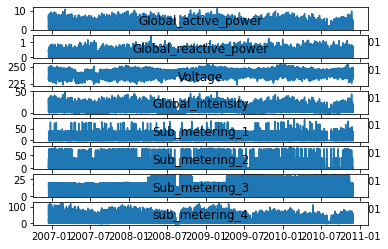

In [ ]:
# line plots
from pandas import read_csv
from matplotlib import pyplot as plt

# line plot for each variable
plt.figure()
for i in range(len(df.columns)):
	plt.subplot(len(df.columns), 1, i+1)
	name = df.columns[i]
	plt.plot(df[name])
	plt.title(name, y=0)
plt.show()

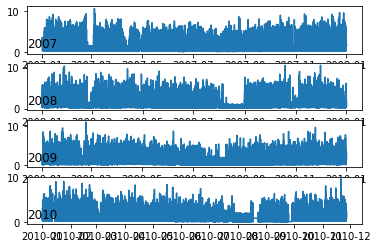

In [ ]:
years=['2007','2008','2009','2010']
plt.figure()
for i in range(len(years)):
    ax = plt.subplot(len(years), 1, i+1)
    year=years[i]
   # get all observations for the year
    result = df[str(year)]
  	# plot the active power for the year
    plt.plot(result['Global_active_power'])
  	# add a title to the subplot
    plt.title(str(year), y=0, loc='left')
plt.show()




In [ ]:
# resample data to daily
df_daily = df.resample('D').sum()

# summarize
print(df_daily.shape)
print(df_daily.head())



(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16          1209.175999  ...    14680.933325
2006-12-17          3390.460002  ...    36946.666703
2006-12-18          2203.826000  ...    19028.433311
2006-12-19          1666.194001  ...    13131.900035
2006-12-20          2225.748000  ...    20384.799997

[5 rows x 8 columns]


In [ ]:
# split into train and test
df_daily=df_daily.reset_index()
predict_period = 365
df_daily_train = df_daily[:-predict_period]
df_daily_test = df_daily[-predict_period:]
df_daily_test

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
1077,2009-11-27,1380.025999,133.052,348276.699661,5703.999997,0.0,396.0,11599.0,11005.433310
1078,2009-11-28,1858.949998,225.218,347898.889954,7784.800011,3199.0,386.0,14350.0,13047.499974
1079,2009-11-29,1650.961998,191.056,350364.559708,6878.399998,1073.0,3061.0,7828.0,15554.033353
1080,2009-11-30,1745.190001,153.382,351020.600143,7232.200008,1080.0,361.0,12039.0,15606.500017
1081,2009-12-01,1756.378002,141.874,349391.739960,7312.800004,0.0,354.0,10821.0,18097.966711
...,...,...,...,...,...,...,...,...,...
1437,2010-11-22,2041.536001,142.354,345883.849976,8660.400010,4855.0,2110.0,10136.0,16924.599998
1438,2010-11-23,1577.535999,137.450,346428.760132,6731.199993,1871.0,458.0,7611.0,16352.266677
1439,2010-11-24,1796.248003,132.460,345644.590164,7559.399989,1096.0,2848.0,12224.0,13769.466663
1440,2010-11-25,1431.164001,116.128,347812.210068,6004.000003,1076.0,426.0,5072.0,17278.733336


In [ ]:

from fbprophet import Prophet
# to train prophet columns should be exactly with this naming
df_daily_train = df_daily_train.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})




In [ ]:
df_daily_test=df_daily_test.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
df_daily_test

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
1077,2009-11-27,1380.025999,133.052,348276.699661,5703.999997,0.0,396.0,11599.0,11005.433310
1078,2009-11-28,1858.949998,225.218,347898.889954,7784.800011,3199.0,386.0,14350.0,13047.499974
1079,2009-11-29,1650.961998,191.056,350364.559708,6878.399998,1073.0,3061.0,7828.0,15554.033353
1080,2009-11-30,1745.190001,153.382,351020.600143,7232.200008,1080.0,361.0,12039.0,15606.500017
1081,2009-12-01,1756.378002,141.874,349391.739960,7312.800004,0.0,354.0,10821.0,18097.966711
...,...,...,...,...,...,...,...,...,...
1437,2010-11-22,2041.536001,142.354,345883.849976,8660.400010,4855.0,2110.0,10136.0,16924.599998
1438,2010-11-23,1577.535999,137.450,346428.760132,6731.199993,1871.0,458.0,7611.0,16352.266677
1439,2010-11-24,1796.248003,132.460,345644.590164,7559.399989,1096.0,2848.0,12224.0,13769.466663
1440,2010-11-25,1431.164001,116.128,347812.210068,6004.000003,1076.0,426.0,5072.0,17278.733336


In [ ]:

# train
m = Prophet()
m.fit(df_daily_train)
# predict
future = m.make_future_dataframe(periods=predict_period)
forecast = m.predict(future)
# get forecast
raw_data_forecast = forecast['yhat'][-predict_period:]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
y_pred=y_pred[-predict_period:]

In [ ]:
y=np.abs(y_true-y_pred)/y_true*100
y=np.array(y)
y.mean()

nan

In [ ]:
y_true=np.array(df_daily_test[['y']])
y_pred=np.array(raw_data_forecast)

In [ ]:
np.mean(np.abs(y_true-y_pred)/y_true*100)


nan

In [ ]:
df_daily_test[['y']]


,y
1077,1380.025999
1078,1858.949998
1079,1650.961998
1080,1745.190001
1081,1756.378002
...,...
1437,2041.536001
1438,1577.535999
1439,1796.248003
1440,1431.164001


Text(0, 0.5, 'Voltage')

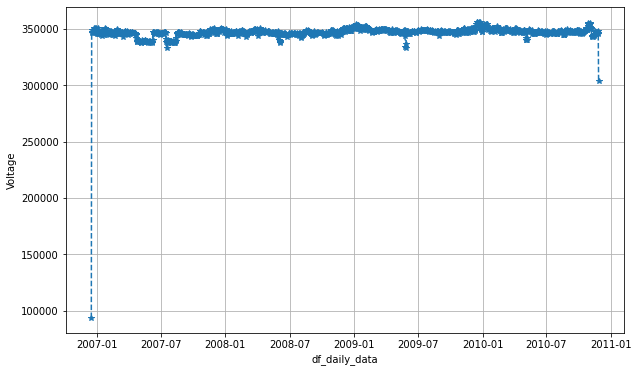

In [ ]:
plt.figure(figsize=( 10 , 6 ))
plt.plot(df_daily.index, df_daily.Voltage, '--' , marker= '*' , )
plt.grid()
plt.xlabel( 'df_daily_data' )
plt.ylabel( 'Voltage' )

Text(0, 0.5, 'Voltage')

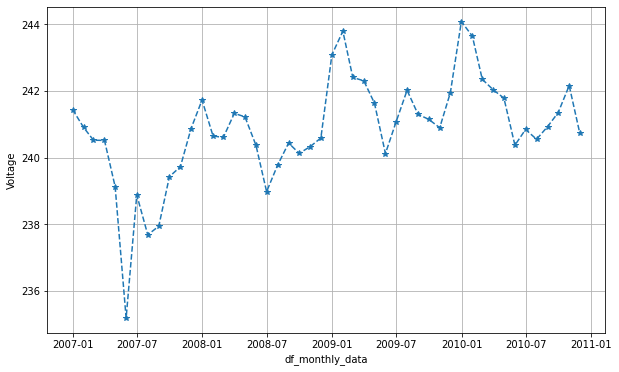

In [ ]:
plt.figure(figsize=( 10 , 6 ))
plt.plot(df_monthly.index, df_monthly.Voltage, '--' , marker= '*' , )
plt.grid()
plt.xlabel( 'df_monthly_data' )
plt.ylabel( 'Voltage' )

Text(0, 0.5, 'Global_active_power')

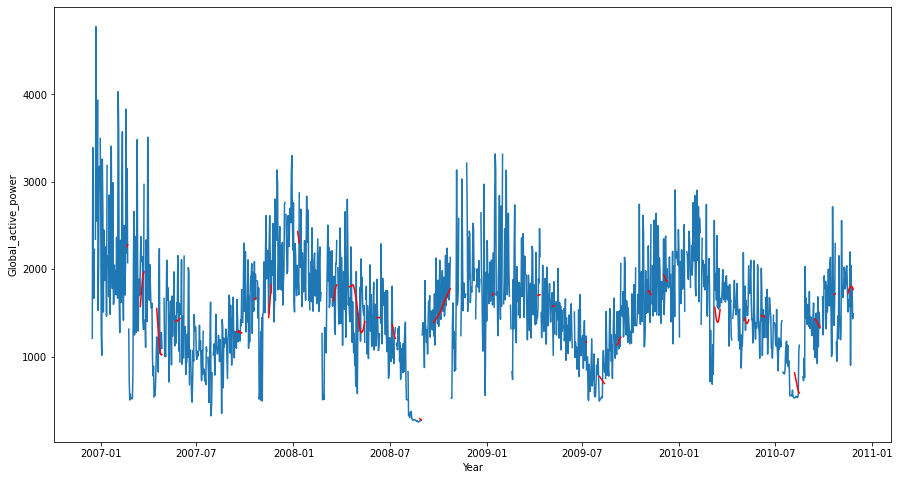

In [ ]:
df_MA = df_daily.copy()
MA = df_MA['Global_active_power'].rolling(12).mean()
plt.plot(df_daily.index, df_daily.Global_active_power, '-')
plt.plot(MA.rolling(12).mean(), color='red')
plt.xlabel( 'Year' )
plt.ylabel( 'Global_active_power' )

In [ ]:
df_MA.corr(method='pearson')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,0.033298,0.063536,0.999181,0.549048,0.477674,0.741040,0.886073
Global_reactive_power,0.033298,1.000000,0.055233,0.054995,0.319715,0.167491,0.033430,-0.106243
Voltage,0.063536,0.055233,1.000000,0.053635,-0.002057,-0.013935,0.096403,0.050710
Global_intensity,0.999181,0.054995,0.053635,1.000000,0.561880,0.487106,0.732817,0.883216
Sub_metering_1,0.549048,0.319715,-0.002057,0.561880,1.000000,0.258590,0.318090,0.360590
Sub_metering_2,0.477674,0.167491,-0.013935,0.487106,0.258590,1.000000,0.200473,0.254462
Sub_metering_3,0.741040,0.033430,0.096403,0.732817,0.318090,0.200473,1.000000,0.454700
sub_metering_4,0.886073,-0.106243,0.050710,0.883216,0.360590,0.254462,0.454700,1.000000


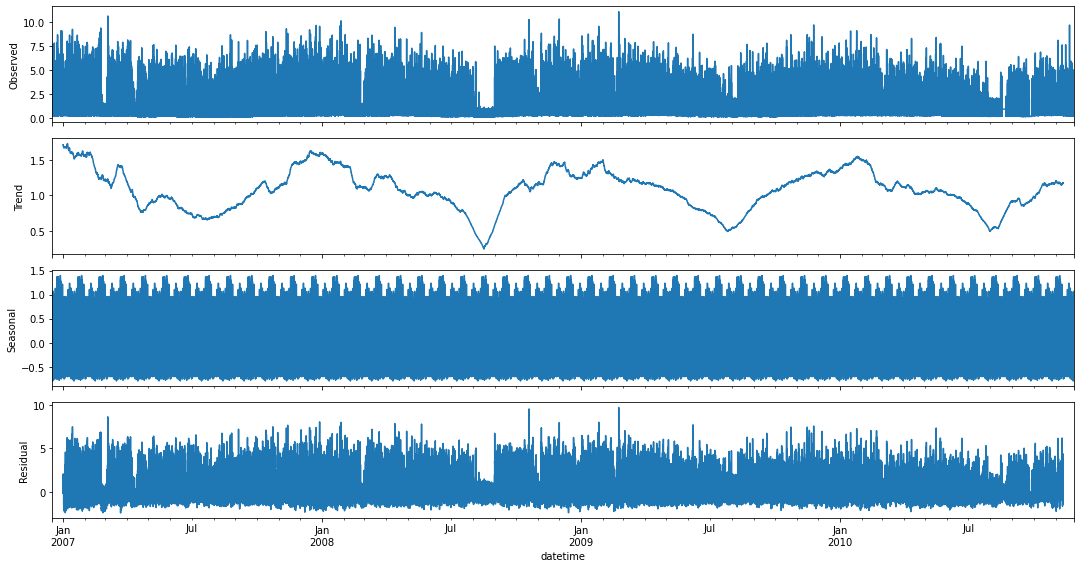

In [ ]:
#Time Series Specific Explanatory Models
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

rcParams['figure.figsize'] = 15, 8

decompose_series = sm.tsa.seasonal_decompose(df['Global_active_power'], model='additive', freq=(60*24*30))
decompose_series.plot()
plt.show()


In [ ]:
#Perform Dickey-Fuller test :Global_active_power/monthly
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_monthly['Global_active_power'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p_value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print(f'Critical_values:')
for k, v in adf_result[4].items():
  print( f'{k} : {v}')


ADF Statistic: -4.616468337438673
p_value: 0.00012043648215814305
No. of lags used: 9
No. of observations used: 38
Critical_values:
1% : -3.6155091011809297
5% : -2.941262357486514
10% : -2.6091995013850418


In [ ]:
#Perform Dickey-Fuller test Global_active_power/DAILY
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_daily['Global_active_power'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p_value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print(f'Critical_values:')
for k, v in adf_result[4].items():
  print( f'{k} : {v}')


ADF Statistic: -3.760052363447818
p_value: 0.0033435202693985534
No. of lags used: 22
No. of observations used: 1419
Critical_values:
1% : -3.434966750462565
5% : -2.8635789736973725
10% : -2.5678555388041384


In [ ]:
#Perform Dickey-Fuller test: Voltage/daily
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_daily['Voltage'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p_value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print(f'Critical_values:')
for k, v in adf_result[4].items():
  print( f'{k} : {v}')


ADF Statistic: -2.9069016767354365
p_value: 0.04455129268589572
No. of lags used: 23
No. of observations used: 1418
Critical_values:
1% : -3.4349700122033804
5% : -2.8635804131233096
10% : -2.567856305330816


In [ ]:
#Perform Dickey-Fuller test :Voltage/monthly
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_monthly['Voltage'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p_value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print(f'Critical_values:')
for k, v in adf_result[4].items():
  print( f'{k} : {v}')


ADF Statistic: -2.5830132326874007
p_value: 0.0965591558557366
No. of lags used: 1
No. of observations used: 46
Critical_values:
1% : -3.5812576580093696
5% : -2.9267849124681518
10% : -2.6015409829867675


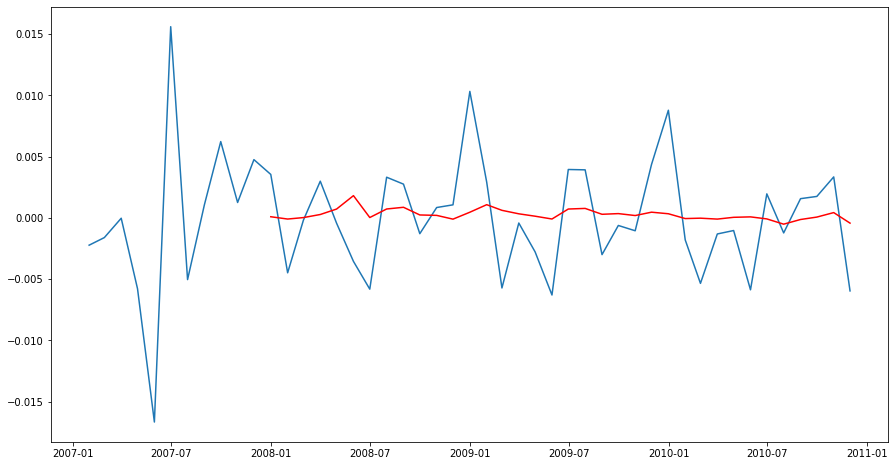

In [ ]:
#transforming non stationary series to stationary(Voltage/monthly)
df_log = np.log(df_monthly['Voltage'])
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index, df_diff, '-')
plt.plot(df_diff.rolling(12).mean(), color='red')

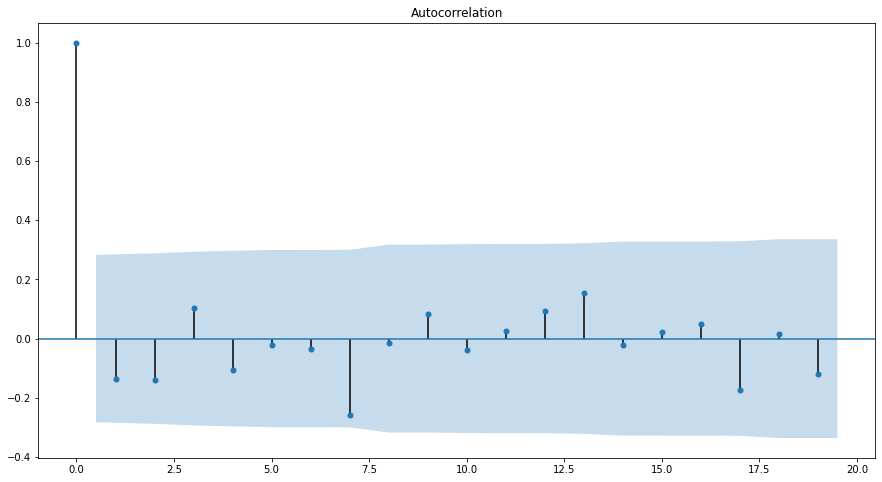

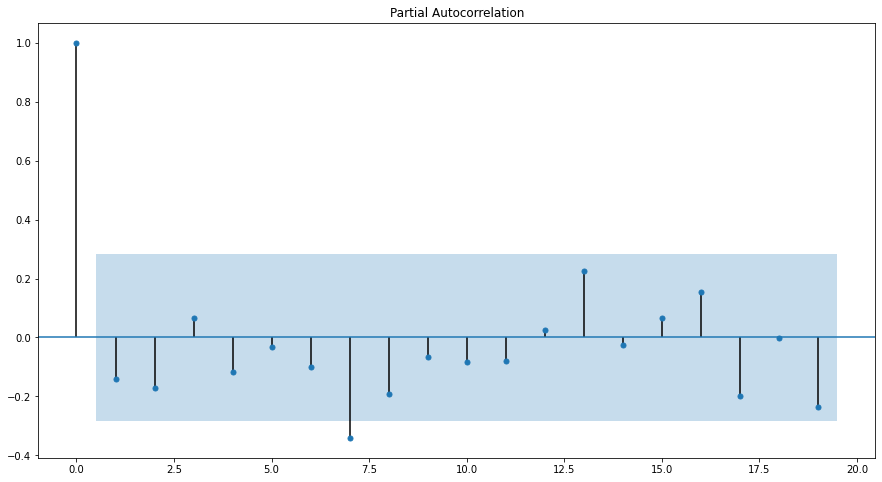

In [ ]:
df_diff = df_diff.fillna(method='bfill')

#Time Series Forecasting Using Stochastic Models
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plot_acf(df_diff, lags = range(0, 20))
plt.show()
#PACF
plot_pacf(df_diff, lags = range(0, 20))
plt.show()

In [ ]:
from fbprophet import Prophet

In [ ]:
df_monthly2=df_monthly.reset_index()
df_monthly2.head()

,level_0,index,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,0,0,2006-12-31,1.901537,0.131400,241.440842,8.030970,1.251864,2.216312,7.409847,20.814259
1,1,1,2007-01-31,1.546085,0.132683,240.904831,6.547132,1.264180,1.775851,7.383759,15.344292
2,2,2,2007-02-28,1.401165,0.113634,240.519180,5.914911,1.180159,1.602282,6.704067,13.866244
3,3,3,2007-03-31,1.318606,0.114747,240.513519,5.572890,1.361313,2.346819,6.504503,11.764133
4,4,4,2007-04-30,0.856787,0.126467,239.127701,3.685574,0.974028,0.889282,4.386643,8.029823


In [ ]:
df_monthly2=df_monthly2[['datetime','Global_active_power']]

In [ ]:
new=df_monthly2.rename(columns={'datetime':'ds','Global_active_power':'y'})
new

,ds,y
0,2006-12-31,1.901537
1,2007-01-31,1.546085
2,2007-02-28,1.401165
3,2007-03-31,1.318606
4,2007-04-30,0.856787
5,2007-05-31,0.985862
6,2007-06-30,0.826887
7,2007-07-31,0.668133
8,2007-08-31,0.763909
9,2007-09-30,0.969442


In [ ]:
model = Prophet()
model.fit(new)

#predict for the next 10 months
future = model.make_future_dataframe(periods=10, freq='M')
forecast = model.predict(future)
forecast.head()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2006-12-31,1.632825,1.534973,1.729641,1.171041,1.171041,1.171041
1,2007-01-31,1.491949,1.390443,1.588149,1.168250,1.168250,1.168250
2,2007-02-28,1.416422,1.319901,1.518748,1.165728,1.165728,1.165728
3,2007-03-31,1.266600,1.172122,1.358869,1.162937,1.162937,1.162937
4,2007-04-30,0.957283,0.852295,1.052808,1.160236,1.160236,1.160236
5,2007-05-31,1.091173,1.002754,1.190105,1.157444,1.157444,1.157444
6,2007-06-30,0.910994,0.814031,1.005750,1.154743,1.154743,1.154743
7,2007-07-31,0.705899,0.609708,0.803667,1.151952,1.151952,1.151952
8,2007-08-31,0.822088,0.726847,0.916320,1.149161,1.149161,1.149161
9,2007-09-30,0.913191,0.814429,1.006269,1.146459,1.146459,1.146459


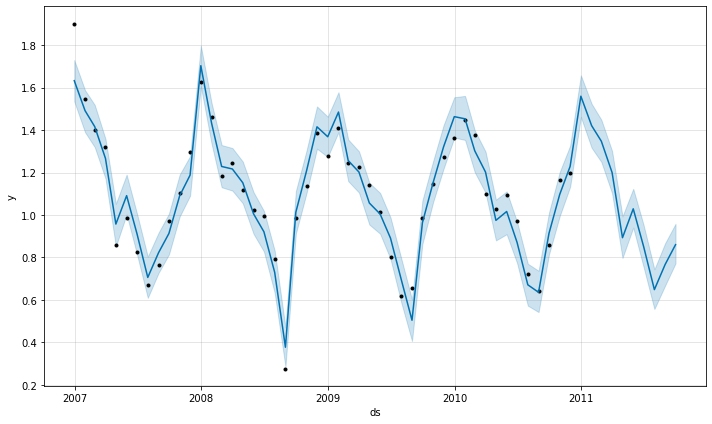

In [ ]:
model.plot(forecast)
plt.show()